## Core Workflow: Download Sentinel-1 and Sentinel-2 images
Search and acquire imagery for a given source, study area, and time period. Prior to acquisition, images can be inspected for conditions such as cloud cover, haziness etc. Alternatively, known ids can be used directly, without searching. Finally, the selected imagery can be downloaded and stored locally.

Replacing all references to bronco packages.

Modified for new architecture in anticipation of Phase IV.  

Date: 2019-01-23  
Author: Peter Kerins  


### Import statements

In [1]:
import warnings
warnings.filterwarnings('ignore')
#
import os
import sys
import json
import itertools
import pickle
from pprint import pprint
#
import numpy as np
import shapely
import cartopy
import geojson
import fiona
import gdal
import h5py
get_ipython().magic(u'matplotlib inline')
import matplotlib.pyplot as plt
import ogr, gdal
import math
from scipy import stats
import collections

import descarteslabs as dl

ULU_REPO = os.environ["ULU_REPO"]
sys.path.append(ULU_REPO+'/utils')
sys.path.append(ULU_REPO)
print(sys.path)

import util_vectors
import util_descartes
import util_imagery

['/home/Taufiq.Rashid/anaconda3/envs/geoml/lib/python36.zip', '/home/Taufiq.Rashid/anaconda3/envs/geoml/lib/python3.6', '/home/Taufiq.Rashid/anaconda3/envs/geoml/lib/python3.6/lib-dynload', '', '/home/Taufiq.Rashid/anaconda3/envs/geoml/lib/python3.6/site-packages', '/home/Taufiq.Rashid/anaconda3/envs/geoml/lib/python3.6/site-packages/IPython/extensions', '/home/Taufiq.Rashid/.ipython', '/home/Taufiq.Rashid/UrbanLandUse/utils', '/home/Taufiq.Rashid/UrbanLandUse']


### Set key variables

In [2]:
place = 'sitapur'

data_root='/data/phase_iv/'
data_path=data_root+place+'/'

tile_resolution = 5
tile_size = 256
tile_pad = 32

processing_level = None
source = 's2'

bands=['blue','green','red','nir','swir1','swir2','alpha']; suffix='BGRNS1S2A'  # S2, Lx
resolution=tile_resolution  # Lx:15 S2:10

#s1_bands=['vv','vh']; s1_suffix='VVVH'  


### Load and inspect study area 

sitapur Sitapur
>>> ogrinfo -al -so /data/phase_iv/sitapur/Sitapur_studyArea.shp
b'INFO: Open of `/data/phase_iv/sitapur/Sitapur_studyArea.shp\'\n      using driver `ESRI Shapefile\' successful.\n\nLayer name: Sitapur_studyArea\nMetadata:\n  DBF_DATE_LAST_UPDATE=2016-07-18\nGeometry: Polygon\nFeature Count: 1\nExtent: (452962.901712, 3030448.248706) - (484367.511519, 3076769.642552)\nLayer SRS WKT:\nPROJCS["WGS 84 / UTM zone 44N",\n    GEOGCS["WGS 84",\n        DATUM["WGS_1984",\n            SPHEROID["WGS 84",6378137,298.257223563,\n                AUTHORITY["EPSG","7030"]],\n            AUTHORITY["EPSG","6326"]],\n        PRIMEM["Greenwich",0,\n            AUTHORITY["EPSG","8901"]],\n        UNIT["degree",0.0174532925199433,\n            AUTHORITY["EPSG","9122"]],\n        AUTHORITY["EPSG","4326"]],\n    PROJECTION["Transverse_Mercator"],\n    PARAMETER["latitude_of_origin",0],\n    PARAMETER["central_meridian",81],\n    PARAMETER["scale_factor",0.9996],\n    PARAMETER["false_easting"

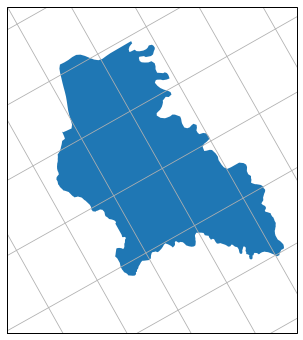

In [3]:
print(place, place.title()) # capitalized version of place name
place_title = place.title()
place_shapefile = data_path+place_title+"_studyAreaEPSG4326.shp"

util_vectors.info_studyareas(data_path, place)

shape = util_vectors.load_shape(place_shapefile)
polygon = shape['geometry']['coordinates']
# print(polygon)
# pprint(shape)
place_bbox = shape['bbox']
# print(bbox)

# using Albers projection
lonlat_crs = cartopy.crs.PlateCarree()
clat, clon = (place_bbox[0]+place_bbox[2])/2.0, (place_bbox[1]+place_bbox[3])/2.0
print("center co-ordinates", clat, clon)
albers = cartopy.crs.AlbersEqualArea(central_latitude=clat, central_longitude=clon)

# visualize Study Region
fig = plt.figure(figsize=(6,6))
ax = plt.subplot(projection=albers) # Specify projection of the map here
shp = shapely.geometry.shape(shape['geometry'])
ax.add_geometries([shp], lonlat_crs)
ax.set_extent((place_bbox[0], place_bbox[2], place_bbox[1], place_bbox[3]), crs=lonlat_crs)
ax.gridlines(crs=lonlat_crs)
plt.show()

### Generate tiles

number of tiles to cover region 587
dict_keys(['geometry', 'type', 'properties'])
tile022 {
  'coordinates': [[[80.54417672689733, 27.654738923241645], [80.56039780033113, 27.6547913102528], [80.56034001206851, 27.669235266940337], [80.54411680645714, 27.669182847947447], [80.54417672689733, 27.654738923241645]]],
  'type': 'Polygon'
}


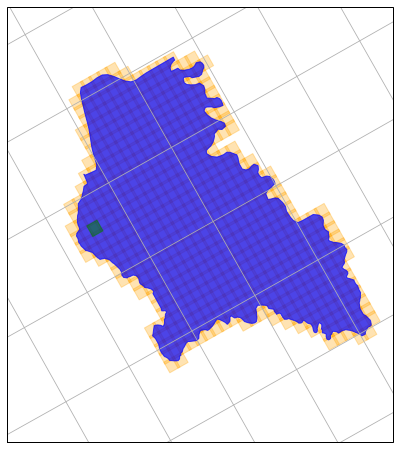

In [4]:
tiles = dl.raster.dltiles_from_shape(tile_resolution, tile_size, tile_pad, shape)
single_tile_id = 22
highlights = {single_tile_id:'green'}
util_vectors.draw_tiled_area(shape, tiles, albers, lonlat_crs, highlights=highlights)

### Search and acquire Sentinel-2 imagery 

In [5]:
product = u'sentinel-2:L1C'
satellite='S2A'

#  Search metadata given a spatio-temporal query
feature_collection = dl.metadata.search(product=[product], start_time='2019-01-01', end_time='2019-11-01', 
                                        cloud_fraction_0=0.5, limit=75, geom=shape['geometry'])
s2_ids = [f['id'] for f in feature_collection['features']]
s2_ids.sort()
print (len(s2_ids), s2_ids)


56 ['sentinel-2:L1C:2019-01-02_44RMR_65_S2B_v1', 'sentinel-2:L1C:2019-01-04_44RMR_83_S2A_v1', 'sentinel-2:L1C:2019-01-07_44RMR_65_S2A_v1', 'sentinel-2:L1C:2019-01-09_44RMR_83_S2B_v1', 'sentinel-2:L1C:2019-01-12_44RMR_65_S2B_v1', 'sentinel-2:L1C:2019-01-14_44RMR_83_S2A_v1', 'sentinel-2:L1C:2019-01-17_44RMR_65_S2A_v1', 'sentinel-2:L1C:2019-01-19_44RMR_83_S2B_v1', 'sentinel-2:L1C:2019-01-22_44RMR_65_S2B_v1', 'sentinel-2:L1C:2019-01-24_44RMR_83_S2A_v1', 'sentinel-2:L1C:2019-01-27_44RMR_65_S2A_v1', 'sentinel-2:L1C:2019-01-29_44RMR_83_S2B_v1', 'sentinel-2:L1C:2019-02-01_44RMR_60_S2B_v1', 'sentinel-2:L1C:2019-02-08_44RMR_83_S2B_v1', 'sentinel-2:L1C:2019-02-16_44RMR_65_S2A_v1', 'sentinel-2:L1C:2019-02-18_44RMR_82_S2B_v1', 'sentinel-2:L1C:2019-02-23_44RMR_83_S2A_v1', 'sentinel-2:L1C:2019-02-28_44RMR_82_S2B_v1', 'sentinel-2:L1C:2019-03-03_44RMR_65_S2B_v1', 'sentinel-2:L1C:2019-03-05_44RMR_82_S2A_v1', 'sentinel-2:L1C:2019-03-08_44RMR_66_S2A_v1', 'sentinel-2:L1C:2019-03-10_44RMR_82_S2B_v1', 'senti

### View image extents

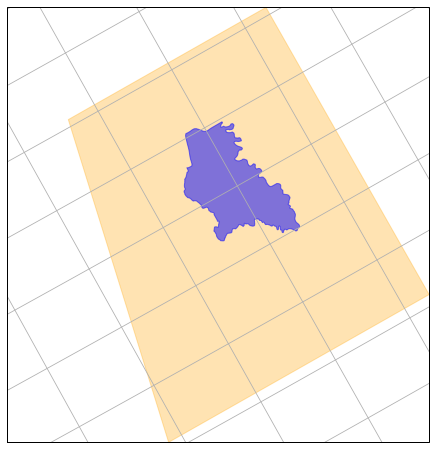

In [6]:
s2_imgs = s2_ids[55:56]

fig = plt.figure(figsize=(8, 8))
ax = plt.subplot(projection=albers) # Specify projection of the map here

shapes = []
for s2_img in s2_imgs:
    metadata = dl.metadata.get(s2_img)
    shapes.append(shapely.geometry.shape(metadata['geometry']))

ax.add_geometries(shapes, lonlat_crs, alpha=0.3, color='orange')
ax.add_geometries([shapely.geometry.shape(shape['geometry'])],
                   lonlat_crs, alpha=0.5, color='blue')

# Get a bounding box of the combined scenes
union = shapely.geometry.MultiPolygon(polygons=shapes)
bbox = union.bounds
ax.set_extent((bbox[0], bbox[2], bbox[1], bbox[3]),crs=lonlat_crs)
ax.gridlines(crs=lonlat_crs)

plt.show()


### Inspect imagery

shape: (579, 393, 4)


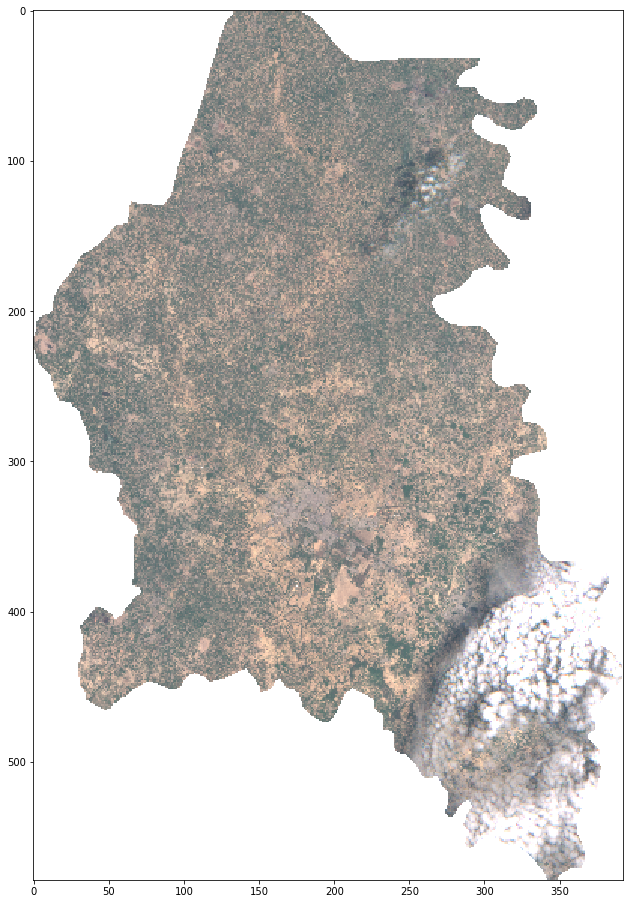

In [7]:
util_descartes.show_scene(s2_imgs[:],bands=['red','green','blue','alpha'],scales=[[0,3000],[0,3000],[0,3000],], geom=shape['geometry'], resolution=80)

### Download imagery 


In [10]:
# pull from api and save to file tiled images: sentinel-2 vir

s2_dict = {}
s2_dict['ZZ'] = [u'sentinel-2:L1C:2019-06-18_44RMR_83_S2B_v1']
# s2_dict['F'] = [u'sentinel-2:L1C:2016-10-16_43QHV_96_S2A_v1']
# s2_dict['G'] = [u'sentinel-2:L1C:2016-10-26_43QHV_97_S2A_v1'] 
# s2_dict['H'] = [u'sentinel-2:L1C:2016-11-25_43QHV_98_S2A_v1']
# s2_dict['Q'] = [u'sentinel-2:L1C:2017-11-30_43QHV_97_S2A_v1']
# s2_dict['R'] = [u'sentinel-2:L1C:2017-12-15_43QHV_97_S2B_v1']
# s2_dict['S'] = [u'sentinel-2:L1C:2017-12-20_43QHV_97_S2A_v1']
# s2_dict['T'] = [u'sentinel-2:L1C:2017-12-25_43QHV_97_S2B_v1']
# s2_dict['U'] = [u'sentinel-2:L1C:2018-01-04_43QHV_97_S2B_v1']
# s2_dict['V'] = [u'sentinel-2:L1C:2018-01-14_43QHV_97_S2B_v1']
# s2_dict['W'] = [u'sentinel-2:L1C:2018-01-24_43QHV_97_S2B_v1'] 

util_imagery.download_imagery(data_root, place, 's2', bands, shape, tiles, s2_dict, processing_level=processing_level)

ZZ ['sentinel-2:L1C:2019-06-18_44RMR_83_S2B_v1']
downloading tile0000: /data/phase_iv/sitapur/imagery/none/sitapur_s2_ZZ_5m_p32_tile0000.tif
downloading tile0001: /data/phase_iv/sitapur/imagery/none/sitapur_s2_ZZ_5m_p32_tile0001.tif
downloading tile0002: /data/phase_iv/sitapur/imagery/none/sitapur_s2_ZZ_5m_p32_tile0002.tif
downloading tile0003: /data/phase_iv/sitapur/imagery/none/sitapur_s2_ZZ_5m_p32_tile0003.tif
downloading tile0004: /data/phase_iv/sitapur/imagery/none/sitapur_s2_ZZ_5m_p32_tile0004.tif
downloading tile0005: /data/phase_iv/sitapur/imagery/none/sitapur_s2_ZZ_5m_p32_tile0005.tif
downloading tile0006: /data/phase_iv/sitapur/imagery/none/sitapur_s2_ZZ_5m_p32_tile0006.tif
downloading tile0007: /data/phase_iv/sitapur/imagery/none/sitapur_s2_ZZ_5m_p32_tile0007.tif
downloading tile0008: /data/phase_iv/sitapur/imagery/none/sitapur_s2_ZZ_5m_p32_tile0008.tif
downloading tile0009: /data/phase_iv/sitapur/imagery/none/sitapur_s2_ZZ_5m_p32_tile0009.tif
downloading tile0010: /data/pha

downloading tile0089: /data/phase_iv/sitapur/imagery/none/sitapur_s2_ZZ_5m_p32_tile0089.tif
downloading tile0090: /data/phase_iv/sitapur/imagery/none/sitapur_s2_ZZ_5m_p32_tile0090.tif
downloading tile0091: /data/phase_iv/sitapur/imagery/none/sitapur_s2_ZZ_5m_p32_tile0091.tif
downloading tile0092: /data/phase_iv/sitapur/imagery/none/sitapur_s2_ZZ_5m_p32_tile0092.tif
downloading tile0093: /data/phase_iv/sitapur/imagery/none/sitapur_s2_ZZ_5m_p32_tile0093.tif
downloading tile0094: /data/phase_iv/sitapur/imagery/none/sitapur_s2_ZZ_5m_p32_tile0094.tif
downloading tile0095: /data/phase_iv/sitapur/imagery/none/sitapur_s2_ZZ_5m_p32_tile0095.tif
downloading tile0096: /data/phase_iv/sitapur/imagery/none/sitapur_s2_ZZ_5m_p32_tile0096.tif
downloading tile0097: /data/phase_iv/sitapur/imagery/none/sitapur_s2_ZZ_5m_p32_tile0097.tif
downloading tile0098: /data/phase_iv/sitapur/imagery/none/sitapur_s2_ZZ_5m_p32_tile0098.tif
downloading tile0099: /data/phase_iv/sitapur/imagery/none/sitapur_s2_ZZ_5m_p32_t

downloading tile0179: /data/phase_iv/sitapur/imagery/none/sitapur_s2_ZZ_5m_p32_tile0179.tif
downloading tile0180: /data/phase_iv/sitapur/imagery/none/sitapur_s2_ZZ_5m_p32_tile0180.tif
downloading tile0181: /data/phase_iv/sitapur/imagery/none/sitapur_s2_ZZ_5m_p32_tile0181.tif
downloading tile0182: /data/phase_iv/sitapur/imagery/none/sitapur_s2_ZZ_5m_p32_tile0182.tif
downloading tile0183: /data/phase_iv/sitapur/imagery/none/sitapur_s2_ZZ_5m_p32_tile0183.tif
downloading tile0184: /data/phase_iv/sitapur/imagery/none/sitapur_s2_ZZ_5m_p32_tile0184.tif
downloading tile0185: /data/phase_iv/sitapur/imagery/none/sitapur_s2_ZZ_5m_p32_tile0185.tif
downloading tile0186: /data/phase_iv/sitapur/imagery/none/sitapur_s2_ZZ_5m_p32_tile0186.tif
downloading tile0187: /data/phase_iv/sitapur/imagery/none/sitapur_s2_ZZ_5m_p32_tile0187.tif
downloading tile0188: /data/phase_iv/sitapur/imagery/none/sitapur_s2_ZZ_5m_p32_tile0188.tif
downloading tile0189: /data/phase_iv/sitapur/imagery/none/sitapur_s2_ZZ_5m_p32_t

downloading tile0269: /data/phase_iv/sitapur/imagery/none/sitapur_s2_ZZ_5m_p32_tile0269.tif
downloading tile0270: /data/phase_iv/sitapur/imagery/none/sitapur_s2_ZZ_5m_p32_tile0270.tif
downloading tile0271: /data/phase_iv/sitapur/imagery/none/sitapur_s2_ZZ_5m_p32_tile0271.tif
downloading tile0272: /data/phase_iv/sitapur/imagery/none/sitapur_s2_ZZ_5m_p32_tile0272.tif
downloading tile0273: /data/phase_iv/sitapur/imagery/none/sitapur_s2_ZZ_5m_p32_tile0273.tif
downloading tile0274: /data/phase_iv/sitapur/imagery/none/sitapur_s2_ZZ_5m_p32_tile0274.tif
downloading tile0275: /data/phase_iv/sitapur/imagery/none/sitapur_s2_ZZ_5m_p32_tile0275.tif
downloading tile0276: /data/phase_iv/sitapur/imagery/none/sitapur_s2_ZZ_5m_p32_tile0276.tif
downloading tile0277: /data/phase_iv/sitapur/imagery/none/sitapur_s2_ZZ_5m_p32_tile0277.tif
downloading tile0278: /data/phase_iv/sitapur/imagery/none/sitapur_s2_ZZ_5m_p32_tile0278.tif
downloading tile0279: /data/phase_iv/sitapur/imagery/none/sitapur_s2_ZZ_5m_p32_t

downloading tile0359: /data/phase_iv/sitapur/imagery/none/sitapur_s2_ZZ_5m_p32_tile0359.tif
downloading tile0360: /data/phase_iv/sitapur/imagery/none/sitapur_s2_ZZ_5m_p32_tile0360.tif
downloading tile0361: /data/phase_iv/sitapur/imagery/none/sitapur_s2_ZZ_5m_p32_tile0361.tif
downloading tile0362: /data/phase_iv/sitapur/imagery/none/sitapur_s2_ZZ_5m_p32_tile0362.tif
downloading tile0363: /data/phase_iv/sitapur/imagery/none/sitapur_s2_ZZ_5m_p32_tile0363.tif
downloading tile0364: /data/phase_iv/sitapur/imagery/none/sitapur_s2_ZZ_5m_p32_tile0364.tif
downloading tile0365: /data/phase_iv/sitapur/imagery/none/sitapur_s2_ZZ_5m_p32_tile0365.tif
downloading tile0366: /data/phase_iv/sitapur/imagery/none/sitapur_s2_ZZ_5m_p32_tile0366.tif
downloading tile0367: /data/phase_iv/sitapur/imagery/none/sitapur_s2_ZZ_5m_p32_tile0367.tif
downloading tile0368: /data/phase_iv/sitapur/imagery/none/sitapur_s2_ZZ_5m_p32_tile0368.tif
downloading tile0369: /data/phase_iv/sitapur/imagery/none/sitapur_s2_ZZ_5m_p32_t

downloading tile0449: /data/phase_iv/sitapur/imagery/none/sitapur_s2_ZZ_5m_p32_tile0449.tif
downloading tile0450: /data/phase_iv/sitapur/imagery/none/sitapur_s2_ZZ_5m_p32_tile0450.tif
downloading tile0451: /data/phase_iv/sitapur/imagery/none/sitapur_s2_ZZ_5m_p32_tile0451.tif
downloading tile0452: /data/phase_iv/sitapur/imagery/none/sitapur_s2_ZZ_5m_p32_tile0452.tif
downloading tile0453: /data/phase_iv/sitapur/imagery/none/sitapur_s2_ZZ_5m_p32_tile0453.tif
downloading tile0454: /data/phase_iv/sitapur/imagery/none/sitapur_s2_ZZ_5m_p32_tile0454.tif
downloading tile0455: /data/phase_iv/sitapur/imagery/none/sitapur_s2_ZZ_5m_p32_tile0455.tif
downloading tile0456: /data/phase_iv/sitapur/imagery/none/sitapur_s2_ZZ_5m_p32_tile0456.tif
downloading tile0457: /data/phase_iv/sitapur/imagery/none/sitapur_s2_ZZ_5m_p32_tile0457.tif
downloading tile0458: /data/phase_iv/sitapur/imagery/none/sitapur_s2_ZZ_5m_p32_tile0458.tif
downloading tile0459: /data/phase_iv/sitapur/imagery/none/sitapur_s2_ZZ_5m_p32_t

downloading tile0539: /data/phase_iv/sitapur/imagery/none/sitapur_s2_ZZ_5m_p32_tile0539.tif
downloading tile0540: /data/phase_iv/sitapur/imagery/none/sitapur_s2_ZZ_5m_p32_tile0540.tif
downloading tile0541: /data/phase_iv/sitapur/imagery/none/sitapur_s2_ZZ_5m_p32_tile0541.tif
downloading tile0542: /data/phase_iv/sitapur/imagery/none/sitapur_s2_ZZ_5m_p32_tile0542.tif
downloading tile0543: /data/phase_iv/sitapur/imagery/none/sitapur_s2_ZZ_5m_p32_tile0543.tif
downloading tile0544: /data/phase_iv/sitapur/imagery/none/sitapur_s2_ZZ_5m_p32_tile0544.tif
downloading tile0545: /data/phase_iv/sitapur/imagery/none/sitapur_s2_ZZ_5m_p32_tile0545.tif
downloading tile0546: /data/phase_iv/sitapur/imagery/none/sitapur_s2_ZZ_5m_p32_tile0546.tif
downloading tile0547: /data/phase_iv/sitapur/imagery/none/sitapur_s2_ZZ_5m_p32_tile0547.tif
downloading tile0548: /data/phase_iv/sitapur/imagery/none/sitapur_s2_ZZ_5m_p32_tile0548.tif
downloading tile0549: /data/phase_iv/sitapur/imagery/none/sitapur_s2_ZZ_5m_p32_t

### Adjusting image files for UTM zone

In [5]:
image_suffix = 'ZZ'

pad   = int(tiles['features'][0]['properties']['pad'])
if resolution==10: 
    zfill=3
elif resolution==5:
    zfill=4
elif resolution==2:
    zfill=5    
else:
    raise Exception('bad resolution: '+str(resolution))
for tile_id in range(len(tiles['features'])):
    
    path = data_root+place+'/imagery/'+str(processing_level).lower()+'/'+\
        place+'_'+source+'_'+image_suffix+'_'+str(resolution)+'m'+'_'+'p'+str(pad)+'_'+'tile'+str(tile_id).zfill(zfill)+'.tif' 
    os.environ['ZRESULTTILE'] = path
    !gdalinfo -proj4 $ZRESULTTILE | grep PROJCS

PROJCS["WGS 84 / UTM zone 44N",
PROJCS["WGS 84 / UTM zone 44N",
PROJCS["WGS 84 / UTM zone 44N",
PROJCS["WGS 84 / UTM zone 44N",
PROJCS["WGS 84 / UTM zone 44N",
PROJCS["WGS 84 / UTM zone 44N",
PROJCS["WGS 84 / UTM zone 44N",
PROJCS["WGS 84 / UTM zone 44N",
PROJCS["WGS 84 / UTM zone 44N",
PROJCS["WGS 84 / UTM zone 44N",
PROJCS["WGS 84 / UTM zone 44N",
PROJCS["WGS 84 / UTM zone 44N",
PROJCS["WGS 84 / UTM zone 44N",
PROJCS["WGS 84 / UTM zone 44N",
PROJCS["WGS 84 / UTM zone 44N",
PROJCS["WGS 84 / UTM zone 44N",
PROJCS["WGS 84 / UTM zone 44N",
PROJCS["WGS 84 / UTM zone 44N",
PROJCS["WGS 84 / UTM zone 44N",
PROJCS["WGS 84 / UTM zone 44N",
PROJCS["WGS 84 / UTM zone 44N",
PROJCS["WGS 84 / UTM zone 44N",
PROJCS["WGS 84 / UTM zone 44N",
PROJCS["WGS 84 / UTM zone 44N",
PROJCS["WGS 84 / UTM zone 44N",
PROJCS["WGS 84 / UTM zone 44N",
PROJCS["WGS 84 / UTM zone 44N",
PROJCS["WGS 84 / UTM zone 44N",
PROJCS["WGS 84 / UTM zone 44N",
PROJCS["WGS 84 / UTM zone 44N",
PROJCS["WGS 84 / UTM zone 44N",
PROJCS["

PROJCS["WGS 84 / UTM zone 44N",
PROJCS["WGS 84 / UTM zone 44N",
PROJCS["WGS 84 / UTM zone 44N",
PROJCS["WGS 84 / UTM zone 44N",
PROJCS["WGS 84 / UTM zone 44N",
PROJCS["WGS 84 / UTM zone 44N",
PROJCS["WGS 84 / UTM zone 44N",
PROJCS["WGS 84 / UTM zone 44N",
PROJCS["WGS 84 / UTM zone 44N",
PROJCS["WGS 84 / UTM zone 44N",
PROJCS["WGS 84 / UTM zone 44N",
PROJCS["WGS 84 / UTM zone 44N",
PROJCS["WGS 84 / UTM zone 44N",
PROJCS["WGS 84 / UTM zone 44N",
PROJCS["WGS 84 / UTM zone 44N",
PROJCS["WGS 84 / UTM zone 44N",
PROJCS["WGS 84 / UTM zone 44N",
PROJCS["WGS 84 / UTM zone 44N",
PROJCS["WGS 84 / UTM zone 44N",
PROJCS["WGS 84 / UTM zone 44N",
PROJCS["WGS 84 / UTM zone 44N",
PROJCS["WGS 84 / UTM zone 44N",
PROJCS["WGS 84 / UTM zone 44N",
PROJCS["WGS 84 / UTM zone 44N",
PROJCS["WGS 84 / UTM zone 44N",
PROJCS["WGS 84 / UTM zone 44N",
PROJCS["WGS 84 / UTM zone 44N",
PROJCS["WGS 84 / UTM zone 44N",
PROJCS["WGS 84 / UTM zone 44N",
PROJCS["WGS 84 / UTM zone 44N",
PROJCS["WGS 84 / UTM zone 44N",
PROJCS["

PROJCS["WGS 84 / UTM zone 44N",
PROJCS["WGS 84 / UTM zone 44N",
PROJCS["WGS 84 / UTM zone 44N",
PROJCS["WGS 84 / UTM zone 44N",
PROJCS["WGS 84 / UTM zone 44N",
PROJCS["WGS 84 / UTM zone 44N",
PROJCS["WGS 84 / UTM zone 44N",
PROJCS["WGS 84 / UTM zone 44N",
PROJCS["WGS 84 / UTM zone 44N",
PROJCS["WGS 84 / UTM zone 44N",
PROJCS["WGS 84 / UTM zone 44N",
PROJCS["WGS 84 / UTM zone 44N",
PROJCS["WGS 84 / UTM zone 44N",
PROJCS["WGS 84 / UTM zone 44N",
PROJCS["WGS 84 / UTM zone 44N",
PROJCS["WGS 84 / UTM zone 44N",
PROJCS["WGS 84 / UTM zone 44N",
PROJCS["WGS 84 / UTM zone 44N",
PROJCS["WGS 84 / UTM zone 44N",
PROJCS["WGS 84 / UTM zone 44N",
PROJCS["WGS 84 / UTM zone 44N",
PROJCS["WGS 84 / UTM zone 44N",
PROJCS["WGS 84 / UTM zone 44N",
PROJCS["WGS 84 / UTM zone 44N",
PROJCS["WGS 84 / UTM zone 44N",
PROJCS["WGS 84 / UTM zone 44N",
PROJCS["WGS 84 / UTM zone 44N",
PROJCS["WGS 84 / UTM zone 44N",
PROJCS["WGS 84 / UTM zone 44N",
PROJCS["WGS 84 / UTM zone 44N",
PROJCS["WGS 84 / UTM zone 44N",
PROJCS["

In [ ]:
index_start = 0
index_stop  = 6

In [ ]:
for t in range(index_start, index_stop):
    os.environ['ZTILESOURCE'] = data_root+place+'/imagery/'+str(processing_level).lower()+'/'+\
        place+'_'+source+'_'+image_suffix+'_'+str(resolution)+'m'+'_'+'p'+str(pad)+'_'+'tile'+str(tile_id).zfill(zfill)+'.tif'
    os.environ['ZTILERESULT'] = data_root+place+'/imagery/'+str(processing_level).lower()+'/'+\
        place+'_'+source+'_'+image_suffix+'_'+str(resolution)+'m'+'_'+'p'+str(pad)+'_'+'tile'+str(tile_id).zfill(zfill)+'_warp.tif'
    !gdalwarp -t_srs '+proj=utm +zone=15 +datum=WGS84 +units=m +no_defs ' $ZTILESOURCE $ZTILERESULT

In [ ]:
for t in range(index_start, index_stop):
    os.environ['ZTILESOURCE'] = data_root+place+'/imagery/'+str(processing_level).lower()+'/'+\
        place+'_'+source+'_'+image_suffix+'_'+str(resolution)+'m'+'_'+'p'+str(pad)+'_'+'tile'+str(tile_id).zfill(zfill)+'_warp.tif'
    os.environ['ZTILERESULT'] = data_root+place+'/imagery/'+str(processing_level).lower()+'/'+\
        place+'_'+source+'_'+image_suffix+'_'+str(resolution)+'m'+'_'+'p'+str(pad)+'_'+'tile'+str(tile_id).zfill(zfill)+'.tif'
    !mv $ZTILESOURCE $ZTILERESULT

### Merge images into mosaic

In [12]:
qmarks = '?????'[0:zfill]
path_template = data_root+place+'/imagery/'+str(processing_level).lower()+'/'+\
    place+'_'+source+'_'+image_suffix+'_'+str(resolution)+'m'+'_'+'p'+str(pad)+'_'+'tile'+qmarks+'.tif'
path_destination = data_root+place+'/imagery/'+str(processing_level).lower()+'/'+\
    place+'_'+source+'_'+image_suffix+'_'+str(resolution)+'m'+'_'+'p'+str(pad)+'_'+'complete'+'.tif'
!gdal_merge.py -n 255 -a_nodata 255 -o {path_destination} {path_template}


0...10...20...30...40...50...60...70...80...90...100 - done.
